# Spatial vs Social coordination

Look at how pairs of participants share movemement, in hall

First load audience motion data (summary QoM), proximity info, concert timing info and then calculate correlations per pair and condition. 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

In [2]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

In [3]:
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [6]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [7]:
concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [8]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
concert_times.iloc[:5]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,sequence
Datetime,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping,Audience Action,946.00,0
2021-10-26 17:36:52,-674.12,-674120,Clapping Off,Audience Action,963.12,1
2021-10-26 17:36:53,-673.12,-673120,Danish,Speech,964.12,2
2021-10-26 17:37:10,-656.12,-656120,English,Speech,981.12,3
2021-10-26 17:37:20,-645.60,-645600,Danish,Speech,991.64,4


In [9]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

,Participant_Code,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Link_Conflicts,Seat_Zone,Location,Longitude_Truncated,Lattitude_Truncated,Offset_1,Offset_2,Watch_Alone
0,ADQ001,1,A,D,Q,0,6.0,NaN,NaN,NaN,0.14,0.16,0.0
1,ADQ002,2,A,D,Q,0,3.0,NaN,NaN,NaN,NaN,-0.36,0.0
2,ADQ003,3,A,D,Q,0,2.0,NaN,NaN,NaN,0.88,1.02,0.0
3,ADQ004,4,A,D,Q,0,4.0,NaN,NaN,NaN,0.44,0.62,1.0
4,ADQ005,5,A,D,Q,0,4.0,NaN,NaN,NaN,0.04,0.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,AEQ086,86,A,E,Q,0,5.0,NaN,NaN,NaN,NaN,0.34,0.0
81,AEQ087,87,A,E,Q,1,3.0,NaN,NaN,NaN,0.12,0.28,0.0
82,AEQ088,88,A,E,Q,0,2.0,NaN,NaN,NaN,0.10,0.06,0.0
83,AEQ089,89,A,E,Q,0,4.0,NaN,NaN,NaN,0.28,0.38,0.0


In [10]:
Main_concert_times[Main_concert_times['Event'].str.contains('Beethoven')]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,sequence
Datetime,,,,,,,
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,8
2021-10-26 17:56:02,476.08,476080,Beethoven 2,Music,2113.32,225.10,9
2021-10-26 17:59:47,701.18,701180,Beethoven 3,Music,2338.42,468.98,10
2021-10-26 18:07:36,1170.16,1170160,Beethoven 4,Music,2807.40,440.20,11
2021-10-26 18:14:56,1610.36,1610360,Clapping for Beethoven,Applause,3247.60,31.64,12
2021-10-26 18:15:48,1662.00,1662000,Survey for Beethoven,Survey,3299.24,330.94,14


In [11]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(aligned_Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(aligned_Part_Codes),:].reset_index(drop = True)
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ021,3.0,0,Stranger
2,ADQ001,ADQ023,-2.0,0,Stranger
3,ADQ001,ADQ024,2.0,0,Stranger
4,ADQ001,ADQ031,-2.0,0,Stranger
...,...,...,...,...,...
565,AEQ082,AEQ083,3.0,0,Stranger
566,AEQ082,AEQ087,3.0,0,Stranger
567,AEQ083,AEQ089,3.0,1,Family_ParentChild
568,AEQ084,AER090,3.0,1,Family_ParentChild


In [15]:
Sub_Rels['Distance'].abs().value_counts()

3.0    344
2.0    175
1.0     51
Name: Distance, dtype: int64

In [17]:
Near_Rels['Distance'].abs().value_counts()

3.0    382
2.0    198
1.0     61
Name: Distance, dtype: int64

In [22]:
Near_Rels['Relationship'].value_counts()

Stranger              558
Friend                 60
Family_ParentChild      8
Family_Partner          6
Friend/Stranger         5
Friend/Absent           4
Name: Relationship, dtype: int64

In [23]:
Sub_Rels['Relationship'].value_counts()

Stranger              495
Friend                 52
Family_ParentChild      8
Family_Partner          6
Friend/Stranger         5
Friend/Absent           4
Name: Relationship, dtype: int64

In [24]:
Sub_Rels['Familiarity'].value_counts()

0    495
1     75
Name: Familiarity, dtype: int64

In [25]:
Near_Rels['Familiarity'].value_counts()

0    558
1     83
Name: Familiarity, dtype: int64

In [11]:
tic = time.time()
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3
        aud_df[part] = b*6
    else:
        aud_df[part] = b
#     if np.nanmedian(b)>0:
#         aud_df[part] = b/np.nanmedian(b)
#     else:
#         aud_df[part] = b/np.nanmean(b)
        
aud_df.index = dt_ct
print(time.time()-tic)

117.63710713386536


## Beethoven

In [20]:
musics = 'Beethoven'

seg_start = concert_times.iloc[50,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[68,:].name
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_times = concert_times[concert_times['Event'].str.contains('Beethoven')]
seg_times = concert_times.iloc[50:68]
#seg_times = concert_times[concert_times['Event'].str.contains('Bach')]
seg_times

[Timestamp('2021-10-26 17:48:46'), Timestamp('2021-10-26 18:21:26')]


,Time_s,Time_ms,Event,Event_Type,Time_Stream,sequence
Datetime,,,,,,
2021-10-26 17:48:46,40.36,40360,Clapping Off,Audience Action,1677.60,50
2021-10-26 17:48:57,50.76,50760,Quiet,Audience Action,1688.00,51
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music Performance,1694.64,52
2021-10-26 17:55:44,457.84,457840,Quiet,Audience Action,2095.08,53
2021-10-26 17:56:02,476.08,476080,Beethoven 2,Music Performance,2113.32,54
2021-10-26 17:59:19,672.98,672980,Quiet,Audience Action,2310.22,55
2021-10-26 17:59:47,701.18,701180,Beethoven 3,Music Performance,2338.42,56
2021-10-26 18:07:20,1154.28,1154280,Quiet,Audience Action,2791.52,57
2021-10-26 18:07:36,1170.16,1170160,Beethoven 4,Music Performance,2807.40,58


In [19]:
musics = 'Schnittke'
seg_start = concert_times.iloc[70,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[89,:].name
seg_times = Main_concert_times[Main_concert_times['Event'].str.contains('Schnitt')]
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
seg_times = concert_times.iloc[70:90]
#seg_times = concert_times[concert_times['Event'].str.contains('Bach')]
#seg_times

[Timestamp('2021-10-26 18:21:42'), Timestamp('2021-10-26 18:46:50')]


In [18]:
musics = 'Bach'
seg_start = concert_times.iloc[122,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[131,:].name
#seg_times = Main_concert_times[Main_concert_times['Event'].str.contains('Schnitt')]
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
seg_times = concert_times.iloc[122:131]
#seg_times = concert_times[concert_times['Event'].str.contains('Bach')]
#seg_times

[Timestamp('2021-10-26 19:15:39'), Timestamp('2021-10-26 19:30:48')]


In [17]:
musics= Folk
seg_start = concert_times.iloc[134,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[177,:].name
seg_times = concert_times.iloc[134:177].copy()
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
seg_times

[Timestamp('2021-10-26 19:32:14'), Timestamp('2021-10-26 20:03:58')]


,Time_s,Time_ms,Event,Event_Type,Time_Stream,sequence
Datetime,,,,,,
2021-10-26 19:32:14,6248.28,6248280,Laughter,Audience Action,7885.52,134
2021-10-26 19:32:18,6251.92,6251920,Clapper,Synchronisation,7889.16,135
2021-10-26 19:32:31,6264.80,6264800,Quiet,Audience Action,7902.04,136
2021-10-26 19:32:37,6271.28,6271280,Folk 1,Music Performance,7908.52,137
2021-10-26 19:40:44,6757.80,6757800,Murmures,Audience Action,8395.04,138
2021-10-26 19:40:45,6758.96,6758960,Clapping,Audience Action,8396.20,139
2021-10-26 19:41:02,6776.30,6776300,Clapping Off,Audience Action,8413.54,140
2021-10-26 19:41:02,6776.48,6776480,Folk 2,Music Performance,8413.72,141
2021-10-26 19:43:39,6932.88,6932880,Murmures,Audience Action,8570.12,142


# qualities of segments

<AxesSubplot:>

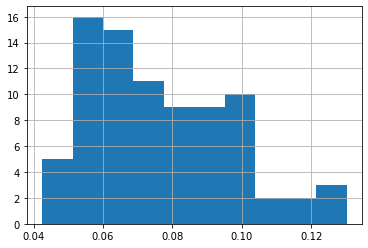

In [21]:
seg_df.median().hist()

In [22]:
seg_df.loc[:,seg_df.median()>0.11].columns

Index(['ADQ016', 'ADQ025', 'ADQ049', 'ADQ066', 'ADR069'], dtype='object')

<AxesSubplot:>

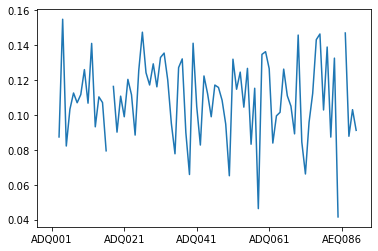

In [23]:
A = seg_df.corr(method = 'spearman')
A.median().plot()

In [24]:
Sub_Rels['Seg_Corr'] = 51
Sub_Rels.loc[Sub_Rels['Distance'] == -2.0,'Distance'] = 2.0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Corr'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [25]:
pg.anova(dv="Seg_Corr",between = ["Distance","Familiarity"], data=Sub_Rels)

C:\Users\finnu\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\finnu\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.004677,2.0,0.002338,1.579326,0.207081,0.005913
1,Familiarity,0.001620,1.0,0.001620,1.094417,0.295971,0.002057
2,Distance * Familiarity,0.000686,2.0,0.000343,0.231557,0.793377,0.000871
3,Residual,0.786210,531.0,0.001481,NaN,NaN,NaN


[Timestamp('2021-10-26 19:41:02'), Timestamp('2021-10-26 19:43:39')]


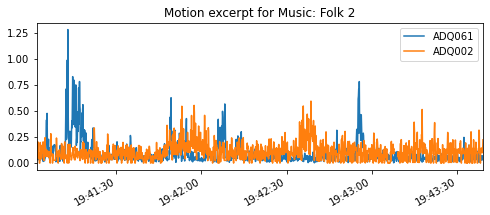

In [26]:
evN = 35
seg_start = Main_concert_times.iloc[evN,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = Main_concert_times.iloc[evN+1,:].name
row = Main_concert_times.iloc[evN,:]
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
#seg_df = seg_df.fillna(0)

seg_df.loc[:,['ADQ061','ADQ002']].plot(figsize=[8,3])
plt.xlim([seg_start,seg_end])
plt.title('Motion excerpt for ' + row['Event_Type'] + ': '+ row['Event'])
plt.savefig('plots/Sample_pair.png',dpi=400)
plt.show()

In [27]:
pg.anova(dv="Seg_Corr",between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.004677,2.0,0.002338,1.579326,0.207081,0.005913
1,Familiarity,0.001620,1.0,0.001620,1.094417,0.295971,0.002057
2,Distance * Familiarity,0.000686,2.0,0.000343,0.231557,0.793377,0.000871
3,Residual,0.786210,531.0,0.001481,NaN,NaN,NaN


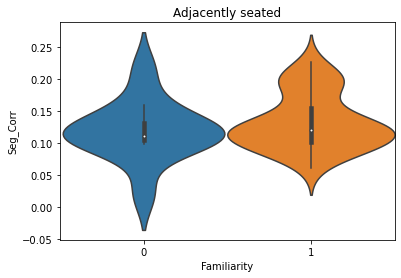

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1     45  0.877757  0.353818  0.019133


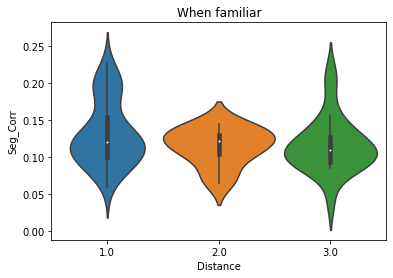

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2     68  1.629795  0.203531  0.045742


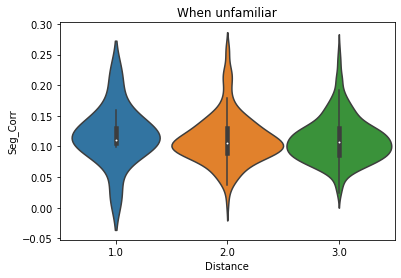

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    463  0.166946  0.846297  0.000721


In [28]:
Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
sns.violinplot(x = 'Familiarity',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('Adjacently seated')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 1]
sns.violinplot(x = 'Distance',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('When familiar')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0]
sns.violinplot(x = 'Distance',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('When unfamiliar')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

In [32]:
Main_concert_times.iloc[:10]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,sequence
Datetime,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,0
2021-10-26 17:36:53,-673.12,-673120,Speech,Speech,964.12,117.08,1
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,2
2021-10-26 17:38:56,-550.16,-550160,Speech,Speech,1087.08,380.52,3
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,105.96,4
2021-10-26 17:47:02,-63.68,-63680,Speech,Speech,1573.56,63.68,5
2021-10-26 17:48:06,0.00,0,Taps 1,Synchronisation,1637.24,14.38,6
2021-10-26 17:48:20,14.38,14380,Clapping for Musicians,Applause,1651.62,43.02,7
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,8


In [52]:
corrs_set = pd.DataFrame()
for i in range(len(Main_concert_times)-1):
    als = Sub_Rels.copy()
    row = Main_concert_times.iloc[i]
    if row['Event_Duration'] >10:
        seg_start = Main_concert_times.iloc[i].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
        seg_end = Main_concert_times.iloc[i+1].name
        print(str([seg_start,seg_end]) + ': ' + row['Event'] + ', ' + row['Event_Type'])
        corr_name = 'Seg_corr'#
        als['Seg_N'] = row['sequence']
        als['Seg_event'] = row['Event']
        als['Seg_type'] = row['Event_Type']
        als['Seg_dur'] = row['Event_Duration']
        als[corr_name] = 0
        seg_df = aud_df.loc[seg_start:seg_end]
        #seg_df = seg_df.fillna(0)
        A = seg_df.corr(method = 'spearman')

        for i,row in Sub_Rels.iterrows():
            if row['Participant_Code_1'] in seg_df.columns:
                if row['Participant_Code_2'] in seg_df.columns:
                    als.loc[i,corr_name] = A[row['Participant_Code_1']][row['Participant_Code_2']]
        corrs_set = pd.concat([corrs_set,als],ignore_index=True)


[Timestamp('2021-10-26 17:36:35'), Timestamp('2021-10-26 17:36:53')]: Clapping for MC, Applause
[Timestamp('2021-10-26 17:36:53'), Timestamp('2021-10-26 17:38:50')]: Speech, Speech
[Timestamp('2021-10-26 17:38:56'), Timestamp('2021-10-26 17:45:16')]: Speech, Speech
[Timestamp('2021-10-26 17:45:16'), Timestamp('2021-10-26 17:47:02')]: Clapping for MC, Applause
[Timestamp('2021-10-26 17:47:02'), Timestamp('2021-10-26 17:48:06')]: Speech, Speech
[Timestamp('2021-10-26 17:48:06'), Timestamp('2021-10-26 17:48:20')]: Taps 1, Synchronisation
[Timestamp('2021-10-26 17:48:20'), Timestamp('2021-10-26 17:49:03')]: Clapping for Musicians, Applause
[Timestamp('2021-10-26 17:49:03'), Timestamp('2021-10-26 17:56:02')]: Beethoven 1, Music
[Timestamp('2021-10-26 17:56:02'), Timestamp('2021-10-26 17:59:47')]: Beethoven 2, Music
[Timestamp('2021-10-26 17:59:47'), Timestamp('2021-10-26 18:07:36')]: Beethoven 3, Music
[Timestamp('2021-10-26 18:07:36'), Timestamp('2021-10-26 18:14:56')]: Beethoven 4, Music


In [53]:
corrs_set['Distance']= corrs_set['Distance'].abs()

In [54]:
sns.set(rc={'figure.figsize':(7,3)})
sns.set_style("whitegrid", {
    "ytick.major.size": 1,
    "ytick.minor.size": 0.5,
    'grid.linestyle': '--',
    "xtick.major.size": 1,
    "xtick.minor.size": 0.5,
    'grid.linestyle': '--'
 })

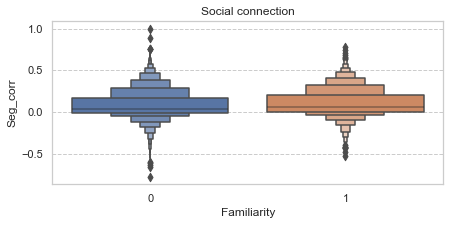

        Source  ddof1  ddof2          F         p-unc       np2
0  Familiarity      1  23223  38.192331  6.517025e-10  0.001642


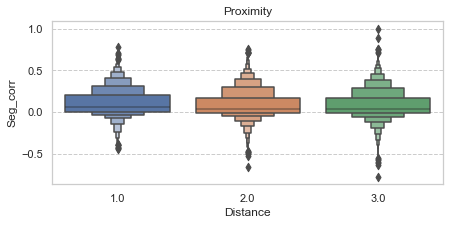

     Source  ddof1  ddof2          F         p-unc       np2
0  Distance      2  23222  15.846626  1.326142e-07  0.001363


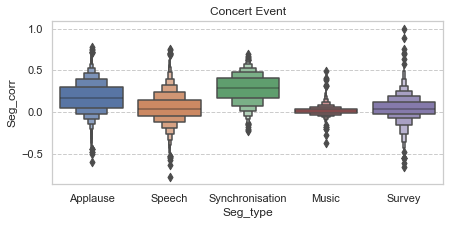

     Source  ddof1  ddof2            F  p-unc       np2
0  Seg_type      4  23220  1631.266329    0.0  0.219366


In [55]:
#sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
#sns.set_theme(style="whitegrid")

sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = corrs_set)
plt.title('Social connection')
plt.savefig('plots/PairCorr_allEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=corrs_set)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr', data = corrs_set)
plt.title('Proximity')
plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=corrs_set)
print(aov)

sns.boxenplot(x = 'Seg_type',y = 'Seg_corr', data = corrs_set)
plt.title('Concert Event')
plt.savefig('plots/PairCorr_allEvents_EventType.png',dpi = 400)

plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_type", data=corrs_set)
print(aov)


In [56]:
pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_type'], data=corrs_set)

,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.326490,1.0,0.326490,14.930920,0.000112,0.000643
1,Distance,0.202354,2.0,0.101177,4.626984,0.009793,0.000399
2,Seg_type,143.052982,4.0,35.763246,1635.512284,0.000000,0.219997
3,Familiarity * Distance,0.131281,2.0,0.065641,3.001859,0.049714,0.000259
4,Familiarity * Seg_type,0.223873,4.0,0.055968,2.559526,0.036630,0.000441
5,Distance * Seg_type,0.134494,8.0,0.016812,0.768831,0.630363,0.000265
6,Familiarity * Distance * Seg_type,0.210751,8.0,0.026344,1.204748,0.291416,0.000415
7,Residual,507.197952,23195.0,0.021867,NaN,NaN,NaN


In [57]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid", {
    "ytick.major.size": 1,
    "ytick.minor.size": 0.5,
    'grid.linestyle': '--',
    "xtick.major.size": 1,
    "xtick.minor.size": 0.5,
    'grid.linestyle': '--'
 })

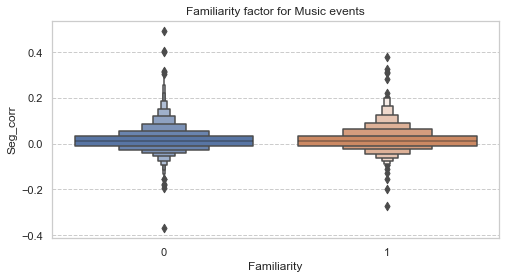

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   6718  3.774959  0.052067  0.000562


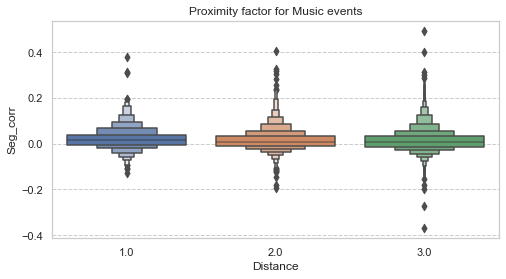

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   6717  6.539707  0.001454  0.001943


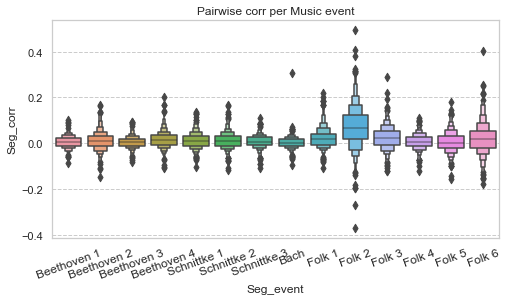

      Source  ddof1  ddof2          F          p-unc       np2
0  Seg_event     13   6706  68.551397  1.338292e-170  0.117303


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.000157,1.0,0.000157,0.078463,7.793997e-01,0.000012
1,Distance,0.022151,2.0,0.011075,5.536532,3.958390e-03,0.001666
2,Seg_event,1.795095,13.0,0.138084,69.028295,1.165361e-171,0.119119
3,Familiarity * Distance,0.007451,2.0,0.003726,1.862468,1.553701e-01,0.000561
4,Familiarity * Seg_event,0.041875,13.0,0.003221,1.610274,7.456798e-02,0.003145
5,Distance * Seg_event,0.086660,26.0,0.003333,1.666210,1.813648e-02,0.006486
6,Familiarity * Distance * Seg_event,0.081194,26.0,0.003123,1.561119,3.451390e-02,0.006079
7,Residual,13.274656,6636.0,0.002000,NaN,NaN,NaN


In [58]:
# look at within type patters
Ev = 'Music'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title('Familiarity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title('Proximity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_event',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title('Pairwise corr per ' + Ev + ' event')
plt.savefig('plots/PairCorr_MusicEvents_Peices.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_event", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_event'], data=Sub_Sub_Rels)

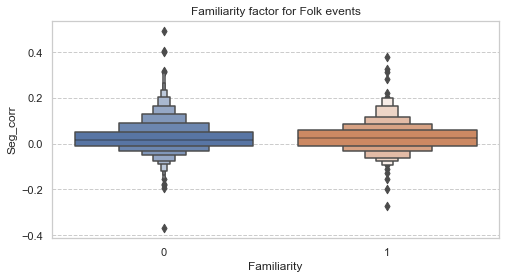

        Source  ddof1  ddof2         F     p-unc      np2
0  Familiarity      1   2645  0.821288  0.364886  0.00031


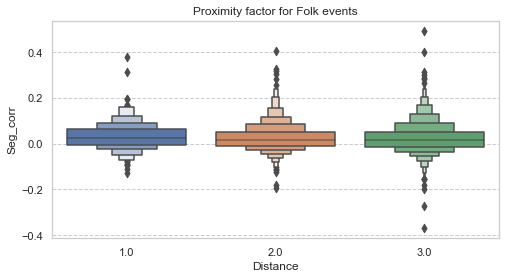

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   2644  2.190618  0.112051  0.001654


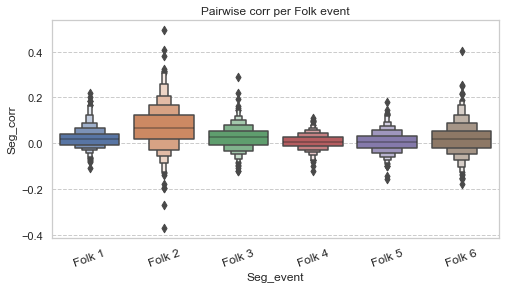

      Source  ddof1  ddof2          F         p-unc       np2
0  Seg_event      5   2641  71.654696  1.670980e-70  0.119453


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.000274,1.0,0.000274,0.078118,7.798867e-01,0.000030
1,Distance,0.015199,2.0,0.007600,2.166560,1.147770e-01,0.001657
2,Seg_event,1.269695,5.0,0.253939,72.395467,3.734380e-71,0.121756
3,Familiarity * Distance,0.025526,2.0,0.012763,3.638596,2.642262e-02,0.002779
4,Familiarity * Seg_event,0.034421,5.0,0.006884,1.962627,8.109353e-02,0.003744
5,Distance * Seg_event,0.071537,10.0,0.007154,2.039453,2.614157e-02,0.007750
6,Familiarity * Distance * Seg_event,0.055969,10.0,0.005597,1.595625,1.015946e-01,0.006074
7,Residual,9.158509,2611.0,0.003508,NaN,NaN,NaN


In [70]:
# look at within type patters
Ev = 'Folk'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_event'].str.startswith(Ev)]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title('Familiarity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title('Proximity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_event',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title('Pairwise corr per ' + Ev + ' event')
plt.savefig('plots/PairCorr_MusicEvents_Peices.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_event", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_event'], data=Sub_Sub_Rels)

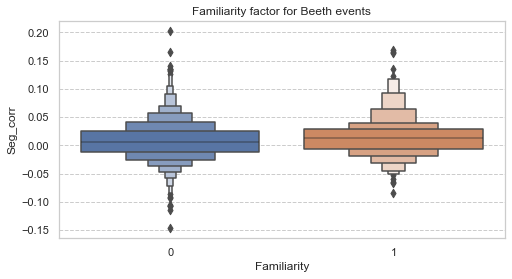

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   2146  7.829019  0.005187  0.003635


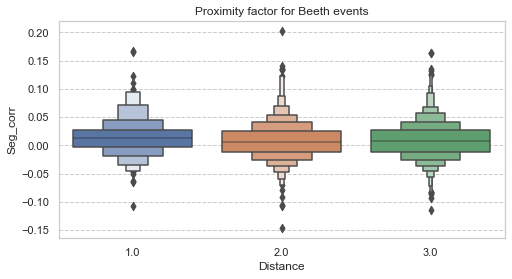

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   2145  3.696303  0.024973  0.003435


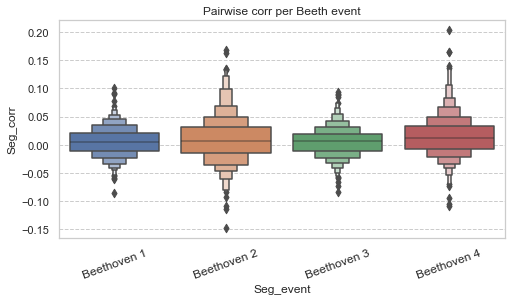

      Source  ddof1  ddof2         F     p-unc       np2
0  Seg_event      3   2144  9.849073  0.000002  0.013594


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.002488,1.0,0.002488,2.354254,0.125091,0.001107
1,Distance,0.002027,2.0,0.001014,0.959182,0.383372,0.000902
2,Seg_event,0.031260,3.0,0.010420,9.859458,0.000002,0.013735
3,Familiarity * Distance,0.000056,2.0,0.000028,0.026447,0.973900,0.000025
4,Familiarity * Seg_event,0.001792,3.0,0.000597,0.565250,0.637941,0.000798
5,Distance * Seg_event,0.007881,6.0,0.001313,1.242840,0.281144,0.003499
6,Familiarity * Distance * Seg_event,0.002673,6.0,0.000446,0.421616,0.865031,0.001190
7,Residual,2.244726,2124.0,0.001057,NaN,NaN,NaN


In [71]:
# look at within type patters
Ev = 'Beeth'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_event'].str.startswith(Ev)]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title('Familiarity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title('Proximity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_event',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title('Pairwise corr per ' + Ev + ' event')
plt.savefig('plots/PairCorr_MusicEvents_Peices.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_event", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_event'], data=Sub_Sub_Rels)

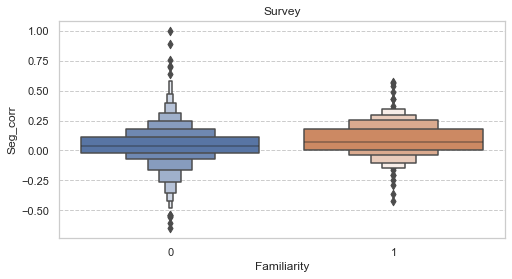

        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   1755  17.768863  0.000026  0.010023


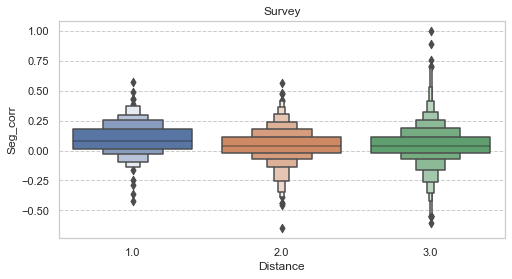

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   1754  7.471059  0.000588  0.008447


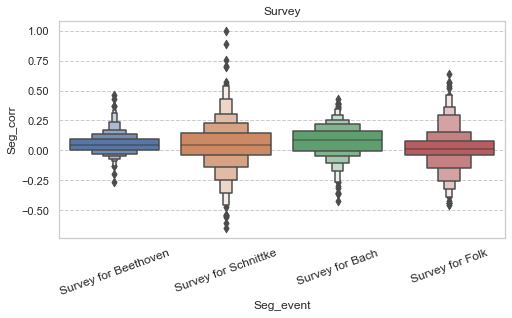

      Source  ddof1  ddof2          F         p-unc       np2
0  Seg_event      3   1753  13.424975  1.157364e-08  0.022459


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.101978,1.0,0.101978,4.937297,2.641181e-02,0.002841
1,Distance,0.068022,2.0,0.034011,1.646655,1.929948e-01,0.001897
2,Seg_event,0.843575,3.0,0.281192,13.613951,8.852686e-09,0.023025
3,Familiarity * Distance,0.009155,2.0,0.004577,0.221615,8.012467e-01,0.000256
4,Familiarity * Seg_event,0.137654,3.0,0.045885,2.221523,8.379394e-02,0.003831
5,Distance * Seg_event,0.089960,6.0,0.014993,0.725906,6.287542e-01,0.002507
6,Familiarity * Distance * Seg_event,0.529037,6.0,0.088173,4.268906,2.811341e-04,0.014565
7,Residual,35.794540,1733.0,0.020655,NaN,NaN,NaN


In [59]:
# look at within type patters
Ev = 'Survey'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_event',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_event", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_event'], data=Sub_Sub_Rels)

In [49]:
corrs_set[corrs_set['Seg_event'] == Ev]

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship,Seg_Corr,Seg_N,Seg_event,Seg_type,Seg_dur,Seg_corr


In [63]:
Sub_Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship,Seg_Corr,Seg_N,Seg_event,Seg_type,Seg_dur,Seg_corr
0,ADQ001,ADQ006,3.0,0,Stranger,0.112981,0,Clapping for MC,Applause,18.12,0.175433
1,ADQ001,ADQ021,3.0,0,Stranger,0.111917,0,Clapping for MC,Applause,18.12,0.276120
2,ADQ001,ADQ023,2.0,0,Stranger,0.127867,0,Clapping for MC,Applause,18.12,0.079931
3,ADQ001,ADQ024,2.0,0,Stranger,0.092888,0,Clapping for MC,Applause,18.12,0.357919
4,ADQ001,ADQ031,2.0,0,Stranger,0.148527,0,Clapping for MC,Applause,18.12,0.125874
...,...,...,...,...,...,...,...,...,...,...,...
27925,AEQ082,AEQ083,3.0,0,Stranger,0.101370,51,Clapping Final,Applause,109.82,NaN
27926,AEQ082,AEQ087,3.0,0,Stranger,0.208912,51,Clapping Final,Applause,109.82,0.108996
27927,AEQ083,AEQ089,3.0,1,Family_ParentChild,0.090108,51,Clapping Final,Applause,109.82,NaN
27928,AEQ084,AER090,3.0,1,Family_ParentChild,0.109298,51,Clapping Final,Applause,109.82,NaN


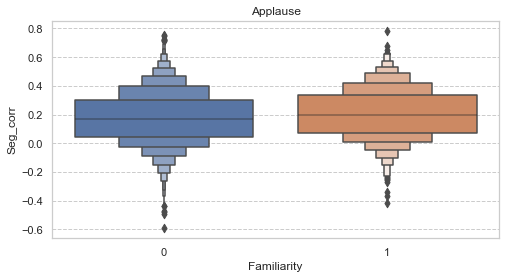

        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   6898  16.846139  0.000041  0.002436


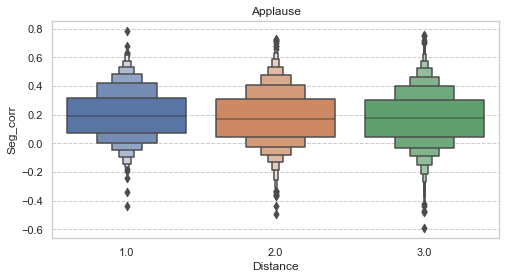

     Source  ddof1  ddof2         F    p-unc       np2
0  Distance      2   6897  3.883187  0.02063  0.001125


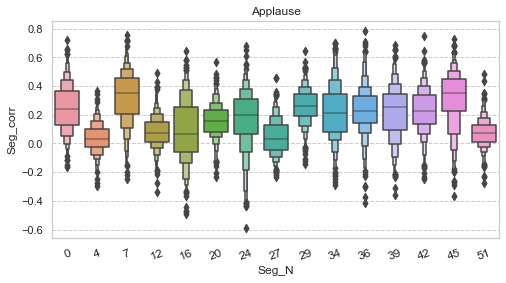

  Source  ddof1  ddof2          F  p-unc       np2
0  Seg_N     14   6885  176.36912    0.0  0.263964


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.359906,1.0,0.359906,14.444793,0.000146,0.002117
1,Distance,0.053520,2.0,0.026760,1.074001,0.341697,0.000315
2,Seg_N,61.753673,14.0,4.410977,177.033939,0.000000,0.266833
3,Familiarity * Distance,0.146651,2.0,0.073326,2.942910,0.052779,0.000864
4,Familiarity * Seg_N,0.531662,14.0,0.037976,1.524155,0.093623,0.003124
5,Distance * Seg_N,0.739350,28.0,0.026405,1.059775,0.379373,0.004338
6,Familiarity * Distance * Seg_N,0.599331,28.0,0.021405,0.859074,0.678497,0.003520
7,Residual,169.677923,6810.0,0.024916,NaN,NaN,NaN


In [62]:
# look at within type patters
Ev = 'Applause'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

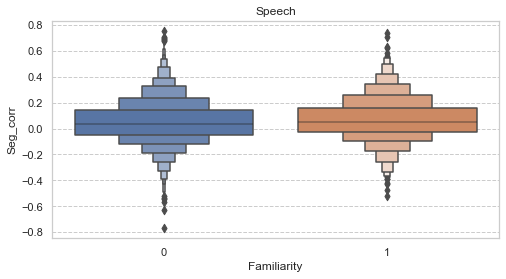

        Source  ddof1  ddof2          F     p-unc      np2
0  Familiarity      1   6864  10.791994  0.001025  0.00157


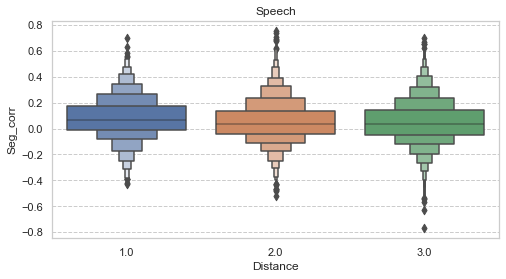

     Source  ddof1  ddof2         F     p-unc      np2
0  Distance      2   6863  7.187682  0.000762  0.00209


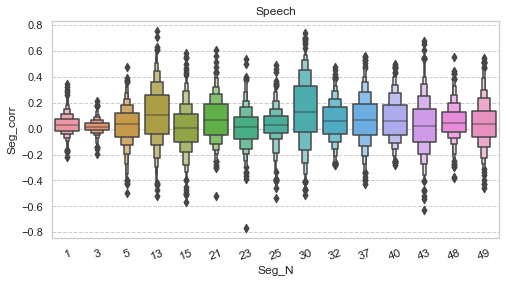

  Source  ddof1  ddof2          F         p-unc      np2
0  Seg_N     14   6851  24.613861  2.778470e-63  0.04789


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.050407,1.0,0.050407,1.865702,1.720135e-01,0.000275
1,Distance,0.147596,2.0,0.073798,2.731476,6.519479e-02,0.000806
2,Seg_N,9.344918,14.0,0.667494,24.705819,1.603755e-63,0.048566
3,Familiarity * Distance,0.172401,2.0,0.086201,3.190530,4.121190e-02,0.000941
4,Familiarity * Seg_N,0.609973,14.0,0.043569,1.612628,6.783105e-02,0.003321
5,Distance * Seg_N,0.616389,28.0,0.022014,0.814796,7.420134e-01,0.003356
6,Familiarity * Distance * Seg_N,0.809678,28.0,0.028917,1.070302,3.651470e-01,0.004403
7,Residual,183.071860,6776.0,0.027018,NaN,NaN,NaN


In [65]:
# look at within type patters
Ev = 'Speech'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

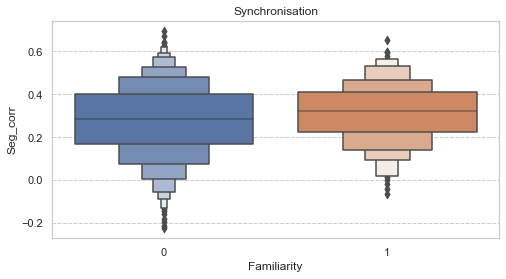

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1    980  5.036884  0.025036  0.005113


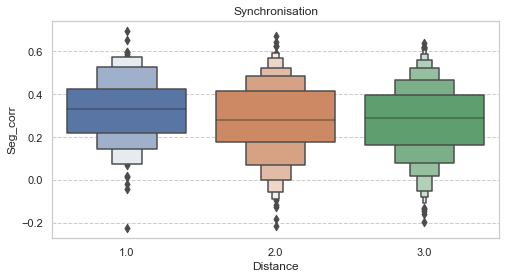

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    979  3.105311  0.045252  0.006304


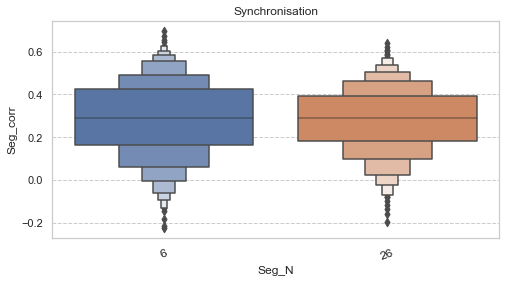

  Source  ddof1  ddof2         F     p-unc       np2
0  Seg_N      1    980  0.154479  0.694377  0.000158


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.027286,1.0,0.027286,0.990391,0.319895,0.001020
1,Distance,0.056029,2.0,0.028014,1.016812,0.362132,0.002092
2,Seg_N,0.004338,1.0,0.004338,0.157458,0.691595,0.000162
3,Familiarity * Distance,0.019329,2.0,0.009664,0.350774,0.704232,0.000723
4,Familiarity * Seg_N,0.117398,1.0,0.117398,4.261095,0.039260,0.004374
5,Distance * Seg_N,0.002221,2.0,0.001111,0.040311,0.960492,0.000083
6,Familiarity * Distance * Seg_N,0.043580,2.0,0.021790,0.790898,0.453729,0.001628
7,Residual,26.724687,970.0,0.027551,NaN,NaN,NaN


In [67]:
# look at within type patters
Ev = 'Synchronisation'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

# Conditions for social attention

The difference between how people move when they know each other vs not across concert events suggests that the activity defines when these people can react to each other. Their access to each other's movement is much the same, but the ammount of attention, or the sensitivity to the information of each others body sway, is different when music is being performed. 